In [185]:
import sys
from itertools import product
from os import listdir
import numpy as np
import scipy.sparse as sparse
import json


# Check quadruplets

In [204]:

# Pull genotypes for a chromosome
famkey = 'AU0001.AU000101.AU000102'
ind_ids = ['AU000103', 'AU000104', 'AU000105', 'AU000106']
data_dir = '../split_gen_ihart'

param_file = '../parameter_estimation/ihart_ind_pass_params.json'

chroms = [str(x) for x in range(1, 23)]

In [206]:
# pull error counts

# chrom, individual, true_variant, observed_variant
errors = np.zeros((len(chroms), 4, 4, 4), dtype=int)
agreement = np.zeros((len(chroms), 4), dtype=int)
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            fk, inds = pieces[:2]
            inds = inds.split('.')

            if fk == famkey:
                for g, c in zip(product([0, 1, 2, 3], repeat=6), pieces[2:]):
                    m = scipy.stats.mode(g)
                    if m.count[0] == 3:
                        error_index = [j for j, x in enumerate(g) if x != m.mode[0]][0]
                        errors[i, error_index, m.mode[0], g[error_index]] += int(c)
                    if m.count[0] == 4:
                        agreement[i, m.mode[0]] += int(c)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [208]:
# pull estimates of error counts

# chrom, individual, true_variant, observed_variant
exp = np.zeros((len(chroms), 4, 4, 4))

with open(param_file, 'r') as f:
    params = json.load(f)

for i, obs in enumerate(['0/0', '0/1', '1/1', './.']):
    for j, true_gen in enumerate(['0/0', '0/1', '1/1']):
        for k, ind in enumerate(ind_ids):
            r = np.power(10.0, -params[ind]["-log10(P[obs=%s|true_gen=%s])" % (obs, true_gen)])
            exp[:, k, j, i] += r*agreement[:, i]



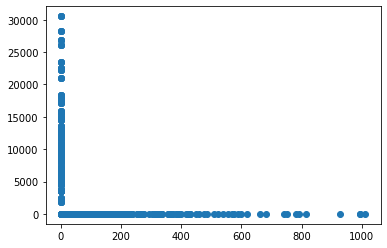

In [209]:
plt.scatter(errors, exp)
plt.show()

# Compare error rates


In [159]:

# chrom, lcl (0, 1, 2, -1), wb (0, 1, 2, -1)
counts = np.zeros((len(chroms), 4, 4, 4, 4))

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

    # pull snp positions
    pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
    snp_positions = pos_data[:, 1]
    is_snp = pos_data[:, 2].astype(bool)
    
    # pull PASS (from GATK)
    is_pass = np.load('%s/chr.%s.pass.npy' % (data_dir, chrom))
        
    offset = 0
    for j, gen_file in enumerate(gen_files):
        print('.%d' % j, end = ' ')
        A = sparse.load_npz('%s/%s' % (data_dir, gen_file))[ind_indexes, :]
        m, n = A.shape
            
        # filter snps
        A = A[:, is_snp[offset:(offset+n)] & is_pass[offset:(offset+n)]].A
        offset += n
            
        # don't need low coverage flag on missing values
        A[A<0] = -1
        
        # count how many times everyone is hom ref
        all_hom_ref = np.all(A==0, axis=0)
        counts[i, 0, 0] += np.sum(all_hom_ref)
            
        # update counts
        gs, cs = np.unique(A[:, ~all_hom_ref], axis=1, return_counts=True)
        for gen, count in zip(gs.T, cs.T):
            counts[i, gen[0], gen[1], gen[2], gen[3]] += count


1 .0 .1 .2 .3 2 .0 .1 .2 .3 3 .0 .1 .2 4 .0 .1 .2 5 .0 .1 .2 6 .0 .1 .2 7 .0 .1 .2 8 .0 .1 .2 9 .0 .1 .2 10 .0 .1 .2 11 .0 .1 12 .0 .1 13 .0 .1 14 .0 .1 15 .0 .1 16 .0 .1 17 .0 .1 18 .0 .1 19 .0 20 .0 21 .0 22 .0 

In [160]:
print(counts.shape)

(22, 4, 4, 4, 4)


In [184]:
# chrom, individual, true_variant, observed_variant
errors = np.zeros((len(chroms), 4, 4, 4), dtype=int)
for gens in product([0, 1, 2, -1], repeat=4):
    for j, ind in enumerate(ind_indexes):
        m = scipy.stats.mode(gens)
        if m.count[0] == 3:
            error_index = [i for i, x in enumerate(gens) if x != m.mode[0]][0]
            errors[:, j, error_index, m.mode[0], gens[error_index]] += counts[:, gens[0], gens[1], gens[2], gens[3]].astype(int)


In [153]:
# obs, true
error_rate_wb = np.zeros((4, 6))
error_rate_lcl = np.zeros((4, 6))
with open(param_file, 'r') as f:
    params = json.load(f)

for i, obs in enumerate(['0/0', '0/1', '1/1', './.']):
    for j, true_gen in enumerate(['0/0', '0/1', '1/1', '-/0', '-/1', '-/-']):
        error_rate_wb[i, j] = np.power(10.0, -params[wb_id]["-log10(P[obs=%s|true_gen=%s])" % (obs, true_gen)])
        error_rate_lcl[i, j] = np.power(10.0, -params[lcl_id]["-log10(P[obs=%s|true_gen=%s])" % (obs, true_gen)])
print(-np.log10(error_rate_wb))
print(-np.log10(error_rate_lcl))

[[2.86039629e-04 2.85473402e+00 5.34791296e+00 3.00652661e-03
  3.66655453e+00 1.81002559e+00]
 [3.48767107e+00 1.06608436e-03 3.23349884e+00 2.66428615e+00
  1.21511932e+00 4.05553295e+00]
 [5.72734429e+00 3.12753202e+00 4.31868833e-04 4.75702620e+00
  2.89531198e-02 2.59982712e+00]
 [3.47990100e+00 3.51006850e+00 3.39220909e+00 2.32650887e+00
  2.47613610e+00 7.92749303e-03]]
[[2.86629289e-04 2.84940020e+00 5.14079442e+00 3.00652661e-03
  3.66655453e+00 1.71412112e+00]
 [3.45167187e+00 9.15856159e-04 3.16689436e+00 2.66428615e+00
  1.21511932e+00 3.93069551e+00]
 [5.72365455e+00 3.42718969e+00 4.74954182e-04 4.75702620e+00
  2.89531198e-02 2.64265673e+00]
 [3.51651116e+00 3.49733020e+00 3.39269669e+00 2.32650887e+00
  2.47613610e+00 9.53171720e-03]]


In [ ]:
# chrom, individual, true_variant, observed_variant
exp = np.zeros((len(chroms), 4, 4, 4))
for i, chrom in enumerate(chroms):
    for true_variant in [-1, 0, 1, 2]:
        exp[i, 0, true_variant, :] += counts[i, true_variant, true_variant, true_variant, true_variant]*error_rate_wb[wb_gen, lcl_gen]
            

In [147]:
#lcl, wb
error_types = [(a, b) for a, b in product([0, 1, 2], repeat=2) if a!=b]
print(error_types)
    
# chrom, lcl, wb
exp = np.zeros((len(chroms), 4, 4))
for i, chrom in enumerate(chroms):
    if chrom != 'X' and chrom != 'Y':
        for lcl_gen, wb_gen in error_types:
            # first, let's say LCL is correct, and the WB is the error
            exp[i, lcl_gen, wb_gen] += counts[i, lcl_gen, lcl_gen]*error_rate_wb[wb_gen, lcl_gen]
            exp[i, lcl_gen, wb_gen] += counts[i, wb_gen, wb_gen]*error_rate_lcl[lcl_gen, wb_gen]
            
            

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


SpearmanrResult(correlation=0.7922077922077924, pvalue=1.1124080778435562e-05)
SpearmanrResult(correlation=0.7591577646142423, pvalue=4.192693991920473e-05)
SpearmanrResult(correlation=0.8159232072275552, pvalue=3.6801812403758083e-06)
SpearmanrResult(correlation=0.8765885692677159, pvalue=8.803826979429251e-08)
SpearmanrResult(correlation=0.6495062239130686, pvalue=0.001070944126767839)
SpearmanrResult(correlation=0.7707509881422926, pvalue=2.6982647336559976e-05)


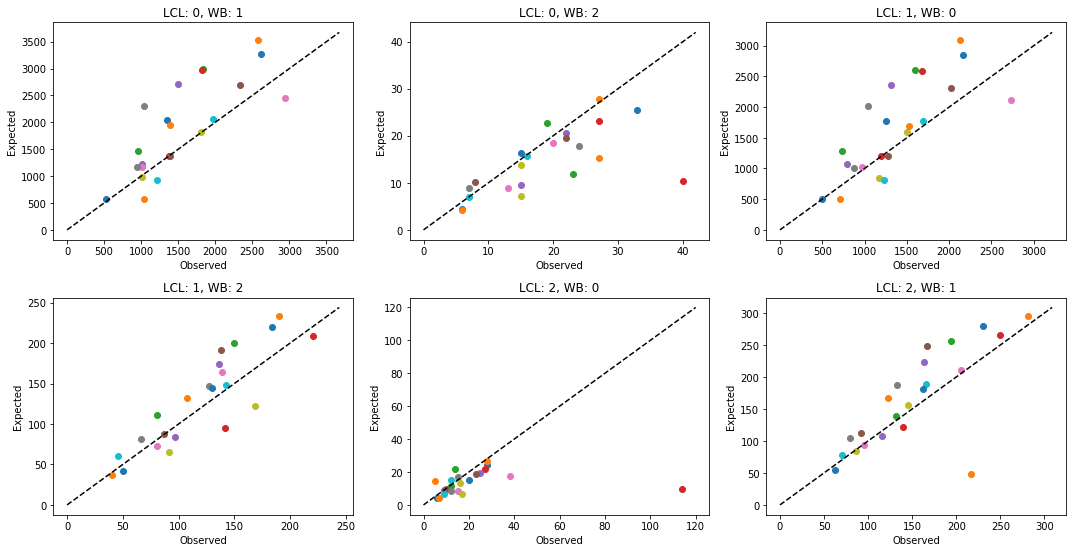

In [149]:
import matplotlib.pyplot as plt
import scipy.stats

plt.figure(figsize=(15, 15))

for i, (lcl_gen, wb_gen) in enumerate(error_types):
    plt.subplot(4, 3, i+1)
    for j, chrom in enumerate(chroms):
        plt.scatter(counts[j, lcl_gen, wb_gen], exp[j, lcl_gen, wb_gen])
    plt.xlabel('Observed')
    plt.ylabel('Expected')
    plt.title('LCL: %d, WB: %d' % (lcl_gen, wb_gen))
    m = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, m], [0, m], color='black', linestyle='--')
    print(scipy.stats.spearmanr(counts[:, lcl_gen, wb_gen], exp[:, lcl_gen, wb_gen]))
    
plt.tight_layout()
plt.show()